In [1]:
import pandas as pd
import numpy as np

In [2]:
sample_train_df = pd.read_csv('../input/talkingdata-adtracking-fraud-detection/train_sample.csv')
sample_train_df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [3]:
sample_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [5]:
sample_train_df['is_attributed'].value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

In [6]:
sample_train_df[~sample_train_df['attributed_time'].isnull()].head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1


### Data exploration

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Univariate analysis:

In [15]:
print(sample_train_df[sample_train_df['is_attributed'] == 0]['ip'].nunique())
print(sample_train_df[sample_train_df['is_attributed'] == 1]['ip'].nunique())

34707
223


The proportion of non-attributed clicks are lower than attributed ones. May be a reapeat of same ips in case of non-attribution case.

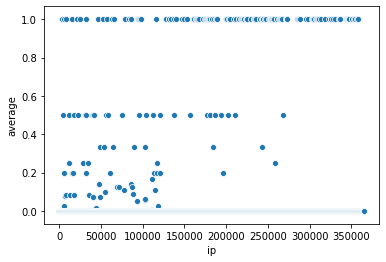

In [45]:
df = sample_train_df.groupby('ip')['is_attributed'].agg(['sum', 'count']).reset_index()
df['average'] = df['sum'] / df['count']

sns.scatterplot(x=df['ip'], y=df['average'])
plt.show()

Clearly some ips have low average conversion.

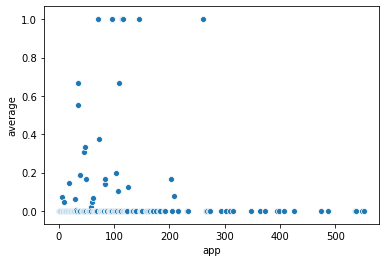

In [46]:
df = sample_train_df.groupby('app')['is_attributed'].agg(['sum', 'count']).reset_index()
df['average'] = df['sum'] / df['count']

sns.scatterplot(x=df['app'], y=df['average'])
plt.show()

Only few apps have good conversion rate.

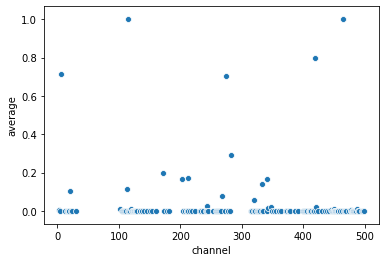

In [47]:
df = sample_train_df.groupby('channel')['is_attributed'].agg(['sum', 'count']).reset_index()
df['average'] = df['sum'] / df['count']

sns.scatterplot(x=df['channel'], y=df['average'])
plt.show()

Only a few channels have good conversion rate.

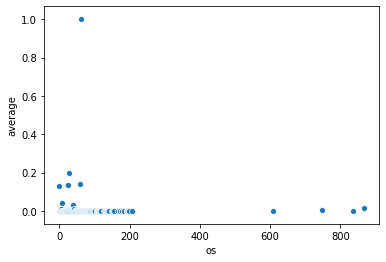

In [48]:
df = sample_train_df.groupby('os')['is_attributed'].agg(['sum', 'count']).reset_index()
df['average'] = df['sum'] / df['count']

sns.scatterplot(x=df['os'], y=df['average'])
plt.show()

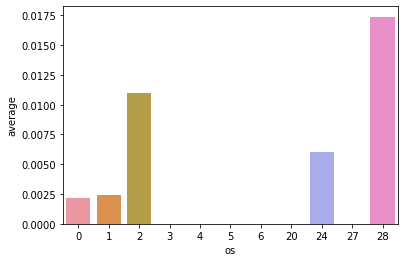

In [77]:
def bin_os(x):
    return x // 30
df = sample_train_df.copy()
df['os'] = df['os'].apply(bin_os)

df = df.groupby('os')['is_attributed'].agg(['sum', 'count']).reset_index()
df['average'] = df['sum'] / df['count']

sns.barplot(x=df['os'], y=df['average'])
plt.show()

OS bin with 30 versions is showing good relation.

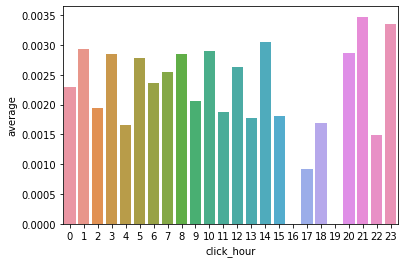

In [53]:
df = sample_train_df.copy()
df['click_hour'] = pd.to_datetime(df['click_time']).dt.hour

df = df.groupby('click_hour')['is_attributed'].agg(['sum', 'count']).reset_index()
df['average'] = df['sum'] / df['count']

sns.barplot(x=df['click_hour'], y=df['average'])
plt.show()

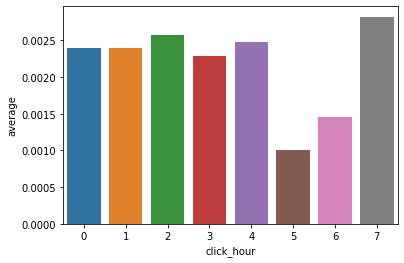

In [61]:
def bin_hour(x):
    return x // 3

df = sample_train_df.copy()
df['click_hour'] = pd.to_datetime(df['click_time']).dt.hour.apply(bin_hour)

df = df.groupby('click_hour')['is_attributed'].agg(['sum', 'count']).reset_index()
df['average'] = df['sum'] / df['count']

sns.barplot(x=df['click_hour'], y=df['average'])
plt.show()

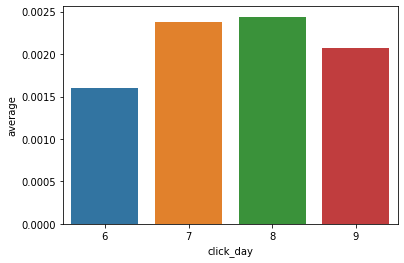

In [56]:
df = sample_train_df.copy()
df['click_day'] = pd.to_datetime(df['click_time']).dt.day

df = df.groupby('click_day')['is_attributed'].agg(['sum', 'count']).reset_index()
df['average'] = df['sum'] / df['count']

sns.barplot(x=df['click_day'], y=df['average'])
plt.show()

Cant use attributed time as it is post event.
Click time is having realtion with hour, when binned in 3 hours.

### Data cleanup and preparation

In [80]:
def cleanup_and_prep(df):
    df['os'] = df['os'].apply(bin_os)
    df['click_hour'] = pd.to_datetime(df['click_time']).dt.hour.apply(bin_hour)
    df = df.drop(columns=['attributed_time', 'click_time'])
    return df
    
prep_df = cleanup_and_prep(sample_train_df)
prep_df.head()

,ip,app,device,os,channel,is_attributed,click_hour
0,87540,12,1,0,497,0,3
1,105560,25,1,0,259,0,4
2,101424,12,1,0,212,0,6
3,94584,13,1,0,477,0,1
4,68413,12,1,0,178,0,3


### Modelling

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X = prep_df.drop(columns=['is_attributed'])
y = prep_df['is_attributed']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [85]:
y_train.sum()/y_train.count()

0.002242857142857143

In [86]:
y_test.sum()/y_test.count()

0.0023333333333333335

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [101]:
params = {'max_depth': np.arange(5, 10),
          'min_samples_leaf': np.arange(50, 1000, 50)}

grid = GridSearchCV(estimator=DecisionTreeClassifier(),
                    param_grid=params,
                    scoring='roc_auc',
                    cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                

In [102]:
grid.best_score_

0.9258007277008424

In [103]:
grid.best_params_

{'max_depth': 8, 'min_samples_leaf': 550}

### Actual model

In [104]:
full_df = pd.read_csv('../input/talkingdata-adtracking-fraud-detection/train.csv')
full_df.shape

(184903890, 8)

In [105]:
pre_full_df = cleanup_and_prep(full_df) 

In [106]:
X = pre_full_df.drop(columns=['is_attributed'])
y = pre_full_df['is_attributed']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [108]:
y_train.sum()/y_train.count()

0.0024712066051488387

In [109]:
y_test.sum()/y_test.count()

0.0024695892913159734

In [110]:
model = DecisionTreeClassifier(max_depth=8,
                               min_samples_leaf=550)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=550, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [111]:
y_pred = model.predict(X_test)

In [112]:
from sklearn.metrics import roc_auc_score

In [113]:
roc_auc_score(y_pred, y_test)

0.872149861306799

### Submission

In [122]:
test_df = pd.read_csv('../input/talkingdata-adtracking-fraud-detection/test.csv')

In [123]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
click_id      int64
ip            int64
app           int64
device        int64
os            int64
channel       int64
click_time    object
dtypes: int64(6), object(1)
memory usage: 1003.5+ MB


In [124]:
submission_df = test_df[['click_id']]

In [125]:
X_test = test_df.copy()
X_test['os'] = X_test['os'].apply(bin_os)
X_test['click_hour'] = pd.to_datetime(X_test['click_time']).dt.hour.apply(bin_hour)
X_test = X_test.drop(columns=['click_id', 'click_time'])

In [126]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 6 columns):
ip            int64
app           int64
device        int64
os            int64
channel       int64
click_hour    int64
dtypes: int64(6)
memory usage: 860.2 MB


In [128]:
submission_df['is_attributed'] = model.predict(X_test)

/home/shakeeb/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [129]:
submission_df.to_csv('submission.csv', index=False)